In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.image as img
from torch import nn
import matplotlib.pyplot as plt

In [ ]:
print(torch.cuda.is_available())

False


In [ ]:
# in pytorch, standart data type is tensors

In [2]:
data = [
    [3,4]
]

pyt_data = torch.tensor(data)
#pyt_data = torch.from_numpy(data) #numpy array to pytorch tensor


In [3]:
batch_size = 64
training_data = datasets.FashionMNIST(root="data",train=True,download=True, transform=ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 19920387.22it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 362898.63it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6083307.68it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17042049.72it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
batch_size = 64 # if pc crash, we may lower the baatch size. how many samples we get at the same time
test_data = datasets.FashionMNIST(root="data",train=False,download=True, transform=ToTensor())
training_data = datasets.FashionMNIST(root="data",train=True,download=True, transform=ToTensor())

In [8]:
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


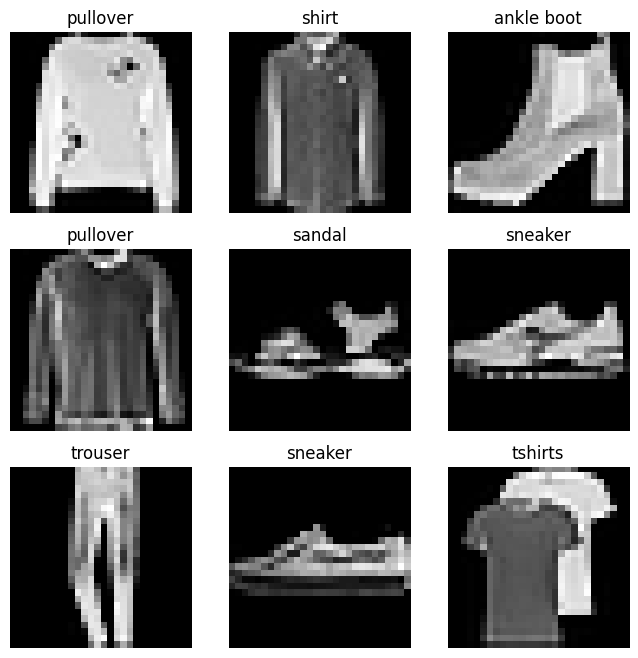

In [ ]:
#label of the dataset
label_map = {
    0:"tshirts",
    1:"trouser",
    2:"pullover",
    3:"dress",
    4:"coat",
    5:"sandal",
    6:"shirt",
    7:"sneaker",
    8:"bag",
    9:"ankle boot"
}

figure = plt.figure(figsize=(8,8))
cols,rows = (3,3)

for i in range(1,cols*rows+1):
  sample_idx = torch.randint(len(training_data),size=(1,)).item()
  img,label = training_data[sample_idx]
  figure.add_subplot(rows,cols,i)
  plt.title(label_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(),cmap="gray")
plt.show()


In [ ]:
# Ax1Bx1xC -> AxBxC squazee removes 1 dims

In [ ]:
# create the model
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class OurMLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(28*28,20), #size of image, output
        nn.Sigmoid(),
        nn.Linear(20,50), # input must be output of 1st layer
        nn.Sigmoid(),
        nn.Linear(50,10) #number of classes (dictionary above)
        #lets say output is 3. [0.2,0.45,0.7] ->  that means input image is 20 percent prob of 1st class ... etc

    )
    self.flatten = nn.Flatten() #takes multidimentional data and make it one dimentional

  def forward(self,x):
    x = self.flatten(x)
    logits = self.mlp(x) #it makes the output between 0 and 1
    return logits
  # there two ways of creating models: squaencial (input of 1st goes to 2nd)
model = OurMLP().to(device) #moving it to cpu

In [ ]:
X = torch.rand(1,28,28)
prediction = model(X)
probability = nn.Softmax(dim=1)(prediction) # make numbers between 0 and 1 y = probability.argmax(1) # we get the highest prob print(y)

In [ ]:
# define hyperparameters
epochs = 3 # how many times our model analyse the data. number of times that you see during the training

learning_rate = 0.001 # amount of the weight change in backward pass. lower rate means, better training however it takes more time

In [ ]:
# define the loss function
loss_fn = nn.CrossEntropyLoss() # we may use any loss functions. it takes arrays of logits and turns into array of prob.
#to compute the error
#define optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)  #it does the backward pass


In [ ]:
#define the training loop
def train_loop(dataloader, model,loss_fn,optimizer):  #dataloader is in change of getting the samples from dataset
  size = len(dataloader) #number of samples
  #get the batch from the dataset
  for batch,(X,y) in enumerate(dataloader):
    #compute prediction and loss
    pred = model(X)
    y_tensor = torch.tensor([y])
    loss = loss_fn(pred,y_tensor)

    #backpropogation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() # zero_grad sets the value of the gradient to zero. if this line is not used, previous gradient will be added to current one

    #print the loss during the training, below line is just to show if accuracy is going well
    if batch % 500 == 0: #every 500 bacches, print the loss
      loss,current = loss.item(),(batch+1)*len(X)
      print(f"loss: {loss} [{current}/{size}]")




In [ ]:
#test loop
def test_loop(dataloader, model, loss_fn):
  #we dont use optimizer bc it is already optimized in training stage, optimizer serves to change the weight
  size = len(dataloader)
  num_batches = len(dataloader)
  test_loss, correct = 0,0
  #disable weight update bc we are testing
  with torch.no_grad():
    for X,y in dataloader:
      pred = model(X)
      y_tensor = torch.tensor([y])
      test_loss += loss_fn(pred,y_tensor).item()
      correct += (pred.argmax(1).type(torch.float).sum().item()) #it gives correctly classified

      #print the accuracy and average loss
      test_loss = test_loss/num_batches
      correct = correct/size
      print(f"accuracy {correct*100}, average loss {test_loss}")


In [ ]:
#train the model
for t in range(epochs): #we pass the data to training_loop number of epoch times
  print(f"epochs: {t}")
  train_loop(training_data,model, loss_fn,optimizer)
  test_loop(test_data,model,loss_fn)


Streaming output truncated to the last 5000 lines.
accuracy 0.020007000300090005, average loss 9.529664041777037e-05
accuracy 0.03000200070003001, average loss 7.372819073391177e-05
accuracy 0.08000300020007, average loss 0.0002137268838511779
accuracy 0.020008000300020007, average loss 0.00010487741078195201
accuracy 0.020002000800030003, average loss 0.0001613334867416275
accuracy 0.03000200020008, average loss 4.5537750284404146e-05
accuracy 0.03000300020002001, average loss 0.00038652212617798254
accuracy 0.09000300030002001, average loss 2.02727750849704e-05
accuracy 0.04000900030003, average loss 0.00013218823743299554
accuracy 0.07000400090003, average loss 0.00011254049390919252
accuracy 7.000400090003001e-06, average loss 3.69608140955869e-05
accuracy 0.08000000070004001, average loss 2.5948465463886367e-05
accuracy 0.04000800000007, average loss 0.00040305931176549167
accuracy 0.0900040008, average loss 0.0001246817243882078
accuracy 9.00040008e-06, average loss 0.00014805587

In [ ]:
# since perceptron requires flattening the dimnetion to 1. and we loose information. it makes mlp not well for images